1: Setup and Imports

In [11]:
# -*- coding: utf-8 -*-
"""weiboner.ipynb"""  # Defines the notebook name and sets UTF-8 encoding for compatibility with Chinese characters

# Mount Google Drive to access dataset and save outputs
from google.colab import drive  # Imports the Google Colab drive module to mount Google Drive
drive.mount('/content/drive')  # Mounts Google Drive to the '/content/drive' directory in Colab

# Define project and dataset paths
project_path = '/content/drive/MyDrive/NLP/NLP_03/'  # Sets the base path for the project in Google Drive
dataset_path = project_path + 'datasets/'  # Constructs the path to the datasets directory
output_dir = project_path + 'output/'  # Constructs the path to the output directory for saving models and results

# Install required packages
!pip install transformers datasets seqeval scikit-learn matplotlib seaborn pandas  # Installs necessary Python libraries using pip

# Import essential libraries
import os  # Imports the os module for interacting with the operating system (e.g., file paths)
import torch  # Imports PyTorch, a deep learning framework
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification  # Imports specific classes from Hugging Face transformers library
from datasets import Dataset  # Imports the Dataset class from Hugging Face datasets for data handling
from seqeval.metrics import classification_report  # Imports classification_report from seqeval for NER evaluation metrics
import numpy as np  # Imports NumPy for numerical operations and array handling
import matplotlib.pyplot as plt  # Imports Matplotlib for creating plots
import seaborn as sns  # Imports Seaborn for enhanced statistical visualizations
from sklearn.metrics import confusion_matrix  # Imports confusion_matrix from scikit-learn for evaluation
import random  # Imports random module for random number generation
import pandas as pd  # Imports pandas for data manipulation and saving results as tables

# Set random seed for reproducibility
seed = 42  # Defines a seed value for consistent random operations
random.seed(seed)  # Sets the random seed for Python's random module
np.random.seed(seed)  # Sets the random seed for NumPy operations
torch.manual_seed(seed)  # Sets the random seed for PyTorch operations on CPU
if torch.cuda.is_available():  # Checks if a GPU (CUDA) is available
    torch.cuda.manual_seed_all(seed)  # Sets the random seed for all GPU devices if CUDA is available
torch.backends.cudnn.deterministic = True  # Ensures CuDNN (CUDA Deep Neural Network library) uses deterministic algorithms
torch.backends.cudnn.benchmark = False  # Disables CuDNN benchmarking to ensure reproducibility over performance optimization

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Selects GPU as device if available, otherwise uses CPU
print(f"Using device: {device}")  # Prints the selected device (e.g., 'cuda' or 'cpu') to confirm hardware usage

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


2: Data Preprocessing

In [12]:
"""2: Data Preprocessing"""  # Section header indicating the data preprocessing module

# Define the list of NER labels based on the dataset
label_list = ["B-GPE.NAM", "B-GPE.NOM", "B-LOC.NAM", "B-LOC.NOM", "B-ORG.NAM", "B-ORG.NOM", "B-PER.NAM", "B-PER.NOM",
              "I-GPE.NAM", "I-GPE.NOM", "I-LOC.NAM", "I-LOC.NOM", "I-ORG.NAM", "I-ORG.NOM", "I-PER.NAM", "I-PER.NOM", "O"]  # Defines all possible NER tags in the dataset
label2id = {label: idx for idx, label in enumerate(label_list)}  # Creates a dictionary mapping each label to a unique integer ID
id2label = {idx: label for label, idx in label2id.items()}  # Creates a reverse dictionary mapping IDs back to labels

# Function to load and preprocess dataset from file
def load_and_preprocess_data(file_path: str) -> list[dict]:  # Defines a function to load and preprocess data with type hints
    """
    Loads dataset and converts it into a list of dictionaries with tokens and NER tags.

    Args:
        file_path (str): Path to the dataset file

    Returns:
        List[Dict]: List of examples with 'tokens' and 'ner_tags'
    """
    data = []  # Initializes an empty list to store the processed dataset
    tokens = []  # Initializes a temporary list to store tokens of a sentence
    tags = []  # Initializes a temporary list to store NER tags of a sentence
    with open(file_path, 'r', encoding='utf-8') as f:  # Opens the dataset file in read mode with UTF-8 encoding
        for line_num, line in enumerate(f, 1):  # Loops through each line in the file, starting line numbers at 1
            line = line.strip()  # Removes leading and trailing whitespace from the line
            if line:  # Checks if the line is not empty (contains token-tag pair)
                try:
                    token, tag = line.split()  # Splits the line into a token and its corresponding NER tag
                    tokens.append(token)  # Adds the token to the tokens list
                    tags.append(tag)  # Adds the NER tag to the tags list
                except ValueError:  # Catches errors if the line cannot be split into exactly two parts
                    print(f"Warning: Malformed line {line_num} in {file_path}: '{line}'. Skipping.")  # Prints a warning for malformed lines
                    continue  # Skips to the next line if an error occurs
            else:  # If the line is empty, it marks the end of a sentence
                if tokens:  # Checks if there are tokens collected for the current sentence
                    data.append({"tokens": tokens, "ner_tags": tags})  # Adds the sentence as a dictionary to the data list
                tokens = []  # Resets the tokens list for the next sentence
                tags = []  # Resets the tags list for the next sentence
        if tokens:  # After the loop, checks if there’s a remaining sentence not followed by an empty line
            data.append({"tokens": tokens, "ner_tags": tags})  # Adds the final sentence to the data list
    return data  # Returns the fully processed dataset as a list of dictionaries

# Load training, development, and test datasets
train_data = load_and_preprocess_data(os.path.join(dataset_path, 'simple_weiboNER_2nd_conll.train'))  # Loads and processes the training dataset
dev_data = load_and_preprocess_data(os.path.join(dataset_path, 'simple_weiboNER_2nd_conll.dev'))  # Loads and processes the development dataset
test_data = load_and_preprocess_data(os.path.join(dataset_path, 'simple_weiboNER_2nd_conll.test'))  # Loads and processes the test dataset

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_list(train_data)  # Converts the training data list into a Hugging Face Dataset object
dev_dataset = Dataset.from_list(dev_data)  # Converts the development data list into a Hugging Face Dataset object
test_dataset = Dataset.from_list(test_data)  # Converts the test data list into a Hugging Face Dataset object

# Print dataset sizes for verification
print(f"Loaded {len(train_dataset)} training examples, {len(dev_dataset)} dev examples, {len(test_dataset)} test examples.")  # Prints the number of examples in each dataset to verify loading

Loaded 1350 training examples, 270 dev examples, 270 test examples.


3: Tokenization

In [13]:
"""3: Tokenization"""  # Section header indicating the tokenization module

# Load the pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("uer/roberta-base-finetuned-cluener2020-chinese")  # Loads a pre-trained tokenizer optimized for Chinese NER

# Function to tokenize input and align labels with subword tokens
def tokenize_and_align_labels(examples: dict) -> dict:  # Defines a function to tokenize data and align labels with type hints
    """
    Tokenizes input tokens and aligns NER tags with subword tokens.

    Args:
        examples (Dict): Dictionary with 'tokens' and 'ner_tags'

    Returns:
        Dict: Tokenized inputs with aligned labels
    """
    # Tokenize without padding for efficiency; padding handled by data collator
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, padding=False)  # Tokenizes the input tokens, truncating if necessary, and indicates pre-split words
    labels = []  # Initializes a list to store aligned labels for all examples
    for i, label in enumerate(examples["ner_tags"]):  # Loops through each example’s NER tags
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Gets the word indices mapping tokenized subwords to original words
        previous_word_idx = None  # Tracks the previous word index to handle subword tokens
        label_ids = []  # Initializes a list to store label IDs for the current example
        for word_idx in word_ids:  # Loops through each word ID in the tokenized sequence
            if word_idx is None:  # Checks if the token is a special token (e.g., [CLS], [SEP])
                label_ids.append(-100)  # Appends -100 to ignore these tokens during loss calculation
            elif word_idx != previous_word_idx:  # Checks if this is the first subword of an original word
                label_ids.append(label2id[label[word_idx]])  # Converts the NER tag to its ID and appends it
            else:  # If it’s a subsequent subword of the same word
                label_ids.append(-100)  # Appends -100 to ignore subword tokens beyond the first
            previous_word_idx = word_idx  # Updates the previous word index for the next iteration
        labels.append(label_ids)  # Adds the aligned label IDs for this example to the labels list
    tokenized_inputs["labels"] = labels  # Adds the aligned labels to the tokenized inputs dictionary
    return tokenized_inputs  # Returns the tokenized inputs with aligned labels

# Apply tokenization to all datasets
tokenized_train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)  # Applies tokenization and label alignment to the training dataset in batches
tokenized_dev_dataset = dev_dataset.map(tokenize_and_align_labels, batched=True)  # Applies tokenization and label alignment to the development dataset in batches
tokenized_test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)  # Applies tokenization and label alignment to the test dataset in batches

print("Tokenization completed.")  # Prints a confirmation message once tokenization is finished

Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/270 [00:00<?, ? examples/s]

Map:   0%|          | 0/270 [00:00<?, ? examples/s]

Tokenization completed.


4: Model Fine-Tuning

In [14]:
"""4: Model Fine-Tuning"""  # Section header indicating the model fine-tuning module

# Define compute_metrics function with per-class metrics and accuracy
def compute_metrics(eval_pred):  # Defines a function to compute evaluation metrics during training/evaluation
    """
    Computes evaluation metrics including accuracy, precision, recall, F1, and per-class metrics.

    Args:
        eval_pred: Evaluation prediction object containing predictions and labels.

    Returns:
        Dict: Dictionary containing accuracy, precision, recall, F1, and per-class metrics.
    """
    predictions, labels = eval_pred  # Unpacks the predictions (logits) and true labels from the eval_pred object
    predictions = np.argmax(predictions, axis=2)  # Converts logits to predicted label IDs by taking the argmax along the label dimension

    # Flatten true and predicted labels, excluding -100
    true_labels_flat = [id2label[l] for label in labels for l in label if l != -100]  # Flattens true labels into a list, converting IDs to labels and excluding ignored tokens (-100)
    pred_labels_flat = [id2label[p] for pred, label in zip(predictions, labels) for p, l in zip(pred, label) if l != -100]  # Flattens predicted labels, aligning with true labels and excluding -100

    # Calculate accuracy
    correct = sum(t == p for t, p in zip(true_labels_flat, pred_labels_flat))  # Counts the number of correct predictions by comparing true and predicted labels
    total = len(true_labels_flat)  # Calculates the total number of valid labels (excluding -100)
    accuracy = correct / total if total > 0 else 0.0  # Computes accuracy as correct predictions divided by total, handling edge case of zero total

    # Prepare labels for seqeval
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]  # Converts true label IDs to labels and groups them by example, excluding -100
    pred_labels = [[id2label[p] for p, l in zip(pred, label) if l != -100] for pred, label in zip(predictions, labels)]  # Converts predicted label IDs to labels, grouped by example, excluding -100

    # Compute classification report using seqeval
    report = classification_report(true_labels, pred_labels, output_dict=True)  # Generates a detailed classification report as a dictionary using seqeval

    # Extract per-class metrics
    per_class_metrics = {cls: report[cls] for cls in report if cls not in ["micro avg", "macro avg", "weighted avg"]}  # Filters out average metrics to keep only per-class metrics

    return {
        "accuracy": accuracy,  # Returns the computed accuracy
        "precision": report["micro avg"]["precision"],  # Returns micro-average precision from the report
        "recall": report["micro avg"]["recall"],  # Returns micro-average recall from the report
        "f1": report["micro avg"]["f1-score"],  # Returns micro-average F1-score from the report
        "per_class_metrics": per_class_metrics  # Returns the dictionary of per-class metrics
    }

# Load the pre-trained model with custom label configuration
model = AutoModelForTokenClassification.from_pretrained(
    "uer/roberta-base-finetuned-cluener2020-chinese",  # Specifies the pre-trained model name optimized for Chinese NER
    num_labels=len(label_list),  # Sets the number of labels to match the dataset’s NER tags
    id2label=id2label,  # Provides the mapping from IDs to labels for the model
    label2id=label2id,  # Provides the mapping from labels to IDs for the model
    ignore_mismatched_sizes=True  # Ignores size mismatches between pre-trained and custom label sets
).to(device)  # Moves the model to the selected device (GPU or CPU)

# Define training arguments with seed and disable wandb
training_args = TrainingArguments(
    output_dir=output_dir,  # Sets the directory where model outputs and checkpoints will be saved
    evaluation_strategy="epoch",  # Configures evaluation to run at the end of each epoch
    save_strategy="epoch",  # Configures model saving to occur at the end of each epoch
    learning_rate=2e-5,  # Sets the learning rate for the optimizer
    per_device_train_batch_size=16,  # Sets the batch size per device for training
    per_device_eval_batch_size=16,  # Sets the batch size per device for evaluation
    num_train_epochs=3,  # Sets the number of epochs to train the model
    weight_decay=0.01,  # Applies weight decay regularization to prevent overfitting
    logging_dir=os.path.join(output_dir, 'logs'),  # Sets the directory for training logs
    logging_steps=10,  # Logs training metrics every 10 steps
    load_best_model_at_end=True,  # Loads the best model (based on metric) at the end of training
    metric_for_best_model="f1",  # Uses F1-score as the metric to determine the best model
    seed=42,  # Sets a seed for reproducibility in training
    report_to="none"  # Disables reporting to external tools like Weights & Biases to avoid API key prompts
)

# Define data collator for dynamic padding
data_collator = DataCollatorForTokenClassification(tokenizer)  # Creates a data collator to dynamically pad tokenized inputs during training

# Initialize the trainer with model, arguments, and datasets
trainer = Trainer(
    model=model,  # Passes the loaded model to the trainer
    args=training_args,  # Passes the defined training arguments
    train_dataset=tokenized_train_dataset,  # Passes the tokenized training dataset
    eval_dataset=tokenized_dev_dataset,  # Passes the tokenized development dataset for evaluation
    compute_metrics=compute_metrics,  # Passes the custom metrics function for evaluation
    data_collator=data_collator  # Passes the data collator for batch processing
)

# Fine-tune the model
print("Starting fine-tuning...")  # Prints a message to indicate the start of fine-tuning
trainer.train()  # Initiates the training process using the trainer
print("Fine-tuning completed.")  # Prints a message to confirm training completion

# Save the fine-tuned model and tokenizer
model.save_pretrained(os.path.join(output_dir, "fine_tuned_model"))  # Saves the fine-tuned model to the specified directory
tokenizer.save_pretrained(os.path.join(output_dir, "fine_tuned_model"))  # Saves the tokenizer to the same directory
print(f"Model saved to {os.path.join(output_dir, 'fine_tuned_model')}")  # Prints the location where the model and tokenizer are saved

Some weights of BertForTokenClassification were not initialized from the model checkpoint at uer/roberta-base-finetuned-cluener2020-chinese and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([32, 768]) in the checkpoint and torch.Size([17, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Per Class Metrics
1,0.125200,0.115416,0.964599,0.542000,0.696658,0.609674,"{'GPE.NAM': {'precision': 0.2222222222222222, 'recall': 0.5384615384615384, 'f1-score': 0.3146067415730337, 'support': 26}, 'GPE.NOM': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'LOC.NAM': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'LOC.NOM': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'ORG.NAM': {'precision': 0.23880597014925373, 'recall': 0.3404255319148936, 'f1-score': 0.28070175438596495, 'support': 47}, 'ORG.NOM': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, 'PER.NAM': {'precision': 0.68, 'recall': 0.7555555555555555, 'f1-score': 0.7157894736842104, 'support': 90}, 'PER.NOM': {'precision': 0.6455223880597015, 'recall': 0.8317307692307693, 'f1-score': 0.7268907563025211, 'support': 208}}"
2,0.093300,0.101453,0.967780,0.599147,0.722365,0.655012,"{'GPE.NAM': {'precision': 0.41304347826086957, 'recall': 0.7307692307692307, 'f1-score': 0.5277777777777778, 'support': 26}, 'GPE.NOM': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'LOC.NAM': {'precision': 0.125, 'recall': 0.16666666666666666, 'f1-score': 0.14285714285714288, 'support': 6}, 'LOC.NOM': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'ORG.NAM': {'precision': 0.2711864406779661, 'recall': 0.3404255319148936, 'f1-score': 0.30188679245283023, 'support': 47}, 'ORG.NOM': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, 'PER.NAM': {'precision': 0.7070707070707071, 'recall': 0.7777777777777778, 'f1-score': 0.7407407407407408, 'support': 90}, 'PER.NOM': {'precision': 0.6809338521400778, 'recall': 0.8413461538461539, 'f1-score': 0.7526881720430108, 'support': 208}}"
3,0.071400,0.096470,0.968886,0.621924,0.714653,0.665072,"{'GPE.NAM': {'precision': 0.45, 'recall': 0.6923076923076923, 'f1-score': 0.5454545454545455, 'support': 26}, 'GPE.NOM': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'LOC.NAM': {'precision': 0.07142857142857142, 'recall': 0.16666666666666666, 'f1-score': 0.1, 'support': 6}, 'LOC.NOM': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'ORG.NAM': {'precision': 0.29310344827586204, 'recall': 0.3617021276595745, 'f1-score': 0.32380952380952377, 'support': 47}, 'ORG.NOM': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, 'PER.NAM': {'precision': 0.7184466019417476, 'recall': 0.8222222222222222, 'f1-score': 0.766839378238342, 'support': 90}, 'PER.NOM': {'precision': 0.7241379310344828, 'recall': 0.8076923076923077, 'f1-score': 0.7636363636363636, 'support': 208}}"


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fine-tuning completed.
Model saved to /content/drive/MyDrive/NLP/NLP_03/output/fine_tuned_model


5: Model Evaluation and Inference

Evaluating on test set...


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test set evaluation results:
eval_loss: 0.1170
eval_accuracy: 0.9654
eval_precision: 0.6156
eval_recall: 0.6627
eval_f1: 0.6382
eval_runtime: 2.6801
eval_samples_per_second: 100.7430
eval_steps_per_second: 6.3430
epoch: 3.0000

Per-class metrics:
         precision    recall  f1-score  support
GPE.NAM   0.622951  0.808511  0.703704       47
GPE.NOM   0.000000  0.000000  0.000000        2
LOC.NAM   0.157895  0.157895  0.157895       19
LOC.NOM   0.000000  0.000000  0.000000        9
ORG.NAM   0.339286  0.487179  0.400000       39
ORG.NOM   0.000000  0.000000  0.000000       17
PER.NAM   0.692913  0.778761  0.733333      113
PER.NOM   0.693548  0.750000  0.720670      172
Per-class metrics saved to /content/drive/MyDrive/NLP/NLP_03/output/per_class_metrics.txt


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Token-level comparison saved to /content/drive/MyDrive/NLP/NLP_03/output/test_token_comparison.csv

Token-level Comparison for Sentence 0:
token true_label predicted_label  is_correct
    一          O               O        True
    节          O               O        True
    课          O               O        True
    的          O               O        True
    时          O               O        True
    间          O               O        True
    真          O               O        True
    心          O               O        True
    感          O               O        True
    动          O               O        True
    了          O               O        True
    李  B-PER.NAM       B-PER.NAM        True
    开  I-PER.NAM       I-PER.NAM        True
    复  I-PER.NAM       I-PER.NAM        True
    感          O               O        True
    动          O               O        True

True Entities for Sentence 0:
Entity: 李开复, Label: PER.NAM, Start: 11

Predicted Entities for Se

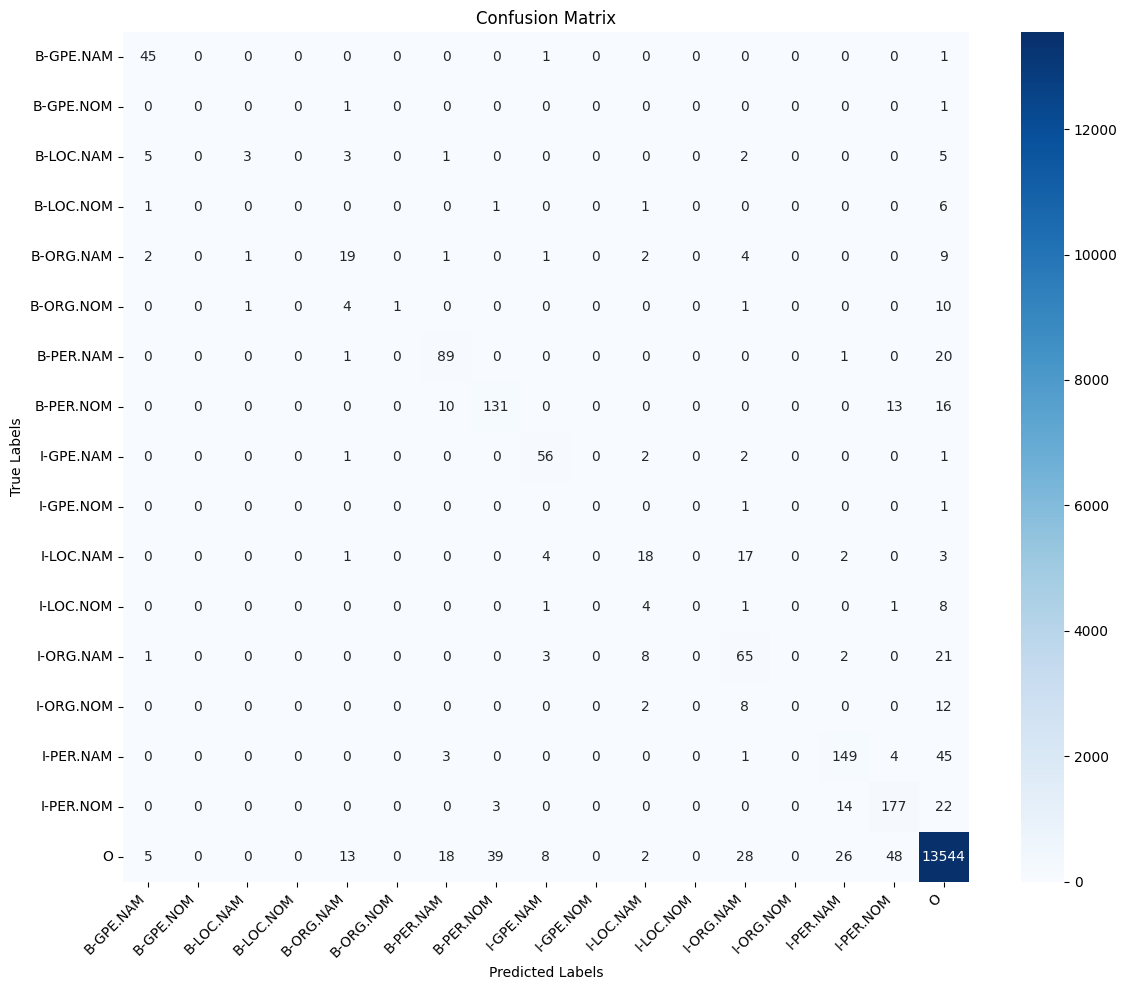

In [16]:
"""5: Model Evaluation and Inference"""  # Section header indicating the evaluation and inference module

import pandas as pd  # Imports pandas library for DataFrame operations
import numpy as np  # Imports numpy library for numerical operations
import matplotlib.pyplot as plt  # Imports matplotlib for plotting
import seaborn as sns  # Imports seaborn for enhanced visualization (e.g., confusion matrix)
import os  # Imports os module for file path operations
from sklearn.metrics import confusion_matrix  # Imports confusion_matrix function from scikit-learn

# Function to extract entities from tokens and labels
def extract_entities(tokens: list[str], labels: list[str]) -> list[dict]:  # Defines a function to extract entities with type hints
    """
    Extracts entities from a list of tokens and their corresponding labels.

    Args:
        tokens (List[str]): List of tokens
        labels (List[str]): List of labels corresponding to each token

    Returns:
        List[Dict]: List of entities with 'text', 'label', and 'start' position
    """
    entities = []  # Initializes an empty list to store extracted entities
    current_entity = {"text": "", "label": "", "start": None}  # Initializes a dictionary for the current entity being built
    for idx, (token, label) in enumerate(zip(tokens, labels)):  # Loops through tokens and labels with their indices
        if label.startswith("B-"):  # Checks if the label indicates the beginning of an entity
            if current_entity["text"]:  # If there’s an ongoing entity, saves it
                entities.append(current_entity)  # Adds the completed entity to the list
            current_entity = {"text": token, "label": label[2:], "start": idx}  # Starts a new entity with the current token
        elif label.startswith("I-") and current_entity["label"] == label[2:]:  # Checks if it’s a continuation of the current entity
            current_entity["text"] += token  # Appends the token to the current entity’s text
        elif label.startswith("I-"):  # Handles stray I- tags not matching the current entity
            print(f"Warning: Stray I- tag '{label}' at position {idx} without matching B-.")  # Prints a warning for invalid I- tags
            if current_entity["text"]:  # If there’s an ongoing entity, saves it
                entities.append(current_entity)  # Adds the completed entity to the list
            current_entity = {"text": "", "label": "", "start": None}  # Resets the current entity
        else:  # Handles O tags or end of an entity
            if current_entity["text"]:  # If there’s an ongoing entity, saves it
                entities.append(current_entity)  # Adds the completed entity to the list
            current_entity = {"text": "", "label": "", "start": None}  # Resets the current entity
    if current_entity["text"]:  # After the loop, checks if there’s a final entity to save
        entities.append(current_entity)  # Adds the last entity to the list
    return entities  # Returns the list of extracted entities

# Evaluate on test set
print("Evaluating on test set...")  # Prints a message to indicate the start of evaluation
eval_results = trainer.evaluate(tokenized_test_dataset)  # Evaluates the model on the tokenized test dataset
print("Test set evaluation results:")  # Prints a header for the evaluation results

# Print overall metrics
for key, value in eval_results.items():  # Loops through each key-value pair in the evaluation results
    if key != "eval_per_class_metrics":  # Checks if the key is not per-class metrics (for overall metrics)
        if isinstance(value, (int, float)):  # Checks if the value is a number (integer or float)
            print(f"{key}: {value:.4f}")  # Prints the metric name and value with 4 decimal places
        else:
            print(f"{key}: {value}")  # Prints non-numeric values as they are

# Extract and display per-class metrics as a table
if "eval_per_class_metrics" in eval_results:  # Checks if per-class metrics are present in the evaluation results
    per_class_metrics = eval_results["eval_per_class_metrics"]  # Extracts the per-class metrics dictionary
    # Create a DataFrame for per-class metrics
    df_per_class = pd.DataFrame.from_dict(per_class_metrics, orient='index')  # Converts the dictionary to a pandas DataFrame with classes as rows
    df_per_class = df_per_class[['precision', 'recall', 'f1-score', 'support']]  # Selects relevant columns for the table
    print("\nPer-class metrics:")  # Prints a header for the per-class metrics table
    print(df_per_class.to_string())  # Prints the DataFrame as a formatted table in the console

    # Save the table to a text file
    txt_path = os.path.join(output_dir, 'per_class_metrics.txt')  # Defines the path to save the per-class metrics text file
    with open(txt_path, 'w') as f:  # Opens the text file in write mode
        f.write(df_per_class.to_string())  # Writes the formatted table to the file
    print(f"Per-class metrics saved to {txt_path}")  # Prints the location where the metrics are saved

# Get predictions for token-level comparison
predictions_output = trainer.predict(tokenized_test_dataset)  # Generates predictions for the test dataset
predicted_label_ids = np.argmax(predictions_output.predictions, axis=-1)  # Converts prediction logits to label IDs by taking the argmax
label_ids = predictions_output.label_ids  # Extracts the true label IDs from the prediction output

comparison_results = []  # Initializes a list to store token-level comparison results
for i in range(len(test_data)):  # Loops through each example in the test data
    tokens = test_data[i]['tokens']  # Extracts the original tokens for the current example
    true_labels = test_data[i]['ner_tags']  # Extracts the original true NER tags for the current example

    # Re-tokenize to get word_ids and determine how many original tokens are kept
    encoded_example = tokenizer(tokens, truncation=True, is_split_into_words=True)  # Tokenizes the tokens again with truncation
    word_ids = encoded_example.word_ids()  # Gets the word IDs mapping subwords to original tokens
    unique_word_ids = [wid for wid in word_ids if wid is not None]  # Filters out None values (special tokens) from word IDs
    num_original_tokens_kept = len(set(unique_word_ids))  # Calculates the number of unique original tokens retained after truncation

    # Collect predicted labels for tokens kept after truncation
    pred_label_ids_example = []  # Initializes a list for predicted label IDs for this example
    previous_word_idx = None  # Tracks the previous word index to avoid duplicate subword labels
    for j, word_id in enumerate(word_ids):  # Loops through word IDs
        if word_id is None:  # Skips special tokens (e.g., [CLS], [SEP])
            continue  # Moves to the next iteration
        elif word_id != previous_word_idx:  # Checks if this is the first subword of a word
            pred_label_ids_example.append(predicted_label_ids[i][j])  # Adds the predicted label ID
            previous_word_idx = word_id  # Updates the previous word index
        if len(pred_label_ids_example) >= num_original_tokens_kept:  # Stops once enough labels are collected
            break  # Exits the loop

    pred_labels = [id2label[p] for p in pred_label_ids_example]  # Converts predicted label IDs to their corresponding labels

    # Ensure lengths match by slicing to number of tokens kept
    tokens = tokens[:num_original_tokens_kept]  # Slices tokens to match the number kept after truncation
    true_labels = true_labels[:num_original_tokens_kept]  # Slices true labels to match the number kept
    assert len(tokens) == len(true_labels) == len(pred_labels), f"Mismatch in lengths for example {i}: {len(tokens)} vs {len(true_labels)} vs {len(pred_labels)}"  # Verifies that all lists have the same length

    # Record comparison results
    for j, token in enumerate(tokens):  # Loops through each token in the example
        true_label = true_labels[j]  # Gets the true label for the current token
        pred_label = pred_labels[j]  # Gets the predicted label for the current token
        is_correct = true_label == pred_label  # Checks if the prediction matches the true label
        comparison_results.append({
            'sentence_id': i,  # Records the sentence ID
            'token': token,  # Records the token text
            'true_label': true_label,  # Records the true NER tag
            'predicted_label': pred_label,  # Records the predicted NER tag
            'is_correct': is_correct  # Records whether the prediction is correct
        })  # Adds the comparison result as a dictionary to the list

# Convert to DataFrame and save
df = pd.DataFrame(comparison_results)  # Converts the comparison results list to a pandas DataFrame
df.to_csv(os.path.join(output_dir, 'test_token_comparison.csv'), index=False)  # Saves the DataFrame to a CSV file without row indices
print(f"Token-level comparison saved to {os.path.join(output_dir, 'test_token_comparison.csv')}")  # Prints the save location

# Print sample comparison for sentence 0
first_sentence_df = df[df['sentence_id'] == 0]  # Filters the DataFrame for sentence ID 0
print("\nToken-level Comparison for Sentence 0:")  # Prints a header for the sample comparison
print(first_sentence_df[['token', 'true_label', 'predicted_label', 'is_correct']].to_string(index=False))  # Prints the comparison for sentence 0 without row indices

# Extract and print true and predicted entities for sentence 0
tokens = test_data[0]['tokens']  # Extracts the tokens for sentence 0
true_labels = test_data[0]['ner_tags']  # Extracts the true NER tags for sentence 0
pred_labels = [id2label[p] for p in [p for p, l in zip(predicted_label_ids[0], label_ids[0]) if l != -100]]  # Extracts predicted labels for sentence 0, excluding -100

true_entities = extract_entities(tokens, true_labels)  # Extracts true entities from tokens and true labels
pred_entities = extract_entities(tokens, pred_labels)  # Extracts predicted entities from tokens and predicted labels

print("\nTrue Entities for Sentence 0:")  # Prints a header for true entities
for entity in true_entities:  # Loops through each true entity
    print(f"Entity: {entity['text']}, Label: {entity['label']}, Start: {entity['start']}")  # Prints the entity text, label, and start position

print("\nPredicted Entities for Sentence 0:")  # Prints a header for predicted entities
for entity in pred_entities:  # Loops through each predicted entity
    print(f"Entity: {entity['text']}, Label: {entity['label']}, Start: {entity['start']}")  # Prints the entity text, label, and start position

# Plot confusion matrix
all_true_labels = []  # Initializes a list to collect all true labels for the confusion matrix
all_pred_labels = []  # Initializes a list to collect all predicted labels for the confusion matrix
for batch in trainer.get_eval_dataloader(tokenized_test_dataset):  # Loops through batches in the test dataloader
    outputs = trainer.model(**batch)  # Gets model outputs (logits) for the current batch
    predictions = np.argmax(outputs.logits.detach().cpu().numpy(), axis=2)  # Converts logits to predicted label IDs
    labels = batch["labels"].cpu().numpy()  # Extracts true label IDs from the batch
    for pred, label in zip(predictions, labels):  # Loops through predictions and labels in the batch
        valid_indices = label != -100  # Identifies indices of valid labels (not -100)
        all_true_labels.extend(label[valid_indices])  # Adds valid true labels to the list
        all_pred_labels.extend(pred[valid_indices])  # Adds valid predicted labels to the list

cm = confusion_matrix(all_true_labels, all_pred_labels, labels=list(label2id.values()))  # Computes the confusion matrix using true and predicted labels
plt.figure(figsize=(12, 10))  # Creates a figure for the confusion matrix with a specified size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)  # Plots the confusion matrix as a heatmap with annotations
plt.xlabel("Predicted Labels")  # Labels the x-axis as "Predicted Labels"
plt.ylabel("True Labels")  # Labels the y-axis as "True Labels"
plt.title("Confusion Matrix")  # Sets the title of the plot
plt.xticks(rotation=45, ha="right")  # Rotates x-axis labels 45 degrees for readability
plt.yticks(rotation=0)  # Keeps y-axis labels horizontal
plt.tight_layout()  # Adjusts the layout to prevent label cutoff
plt.show()  # Displays the confusion matrix plot